# **TP04 - Análisis de Discriminante y Vecinos más cercanos**

<p align=center>
    <image src="https://github.com/walteraguirre/TPS/blob/main/TP04/imagenes/introduccion.png?raw=true" alt="tp04">
</p>


## **Exploración de datos**

<p align=center>
    <image src = "https://github.com/walteraguirre/TPS/blob/main/TP04/imagenes/ej1.png?raw=true" alt="exploración de datos">
</p>


---


Para obtener el dataset con el que vamos a trabajar, vamos a utilizar el comando `load_iris()` de la librería `sklearn`. Esto descarga la base de datos **Iris**, que es un diccionario que contiene varios elementos útiles para el análisis. 

Nosotros en particular nos vamos a quedar con las dos primeras columnas del atributo `iris.data` correspondientes a las dimensiones del largo y ancho del sépalo respectivamente. Tambien nos quedamos con los datos del atributo `iris.target` que contiene las etiquetas $(0, \ 1, \ 2)$ correspondientes a las especies a la que corresponde cada muestra, estas especies son: setosa, versicolor o virginica respectivamente.

Una vez que tenemos los datos, vamos a dividir los conjuntos de entrenamiento y de testeo con `train_test` de la librería `sklearn`, en particular si queremos dividir los conjuntos de forma tal que el $70\%$ de los datos sean parte del conjunto de entrenamiento y el $30\%$ sean parte del conjunto de testeo, vamos a setear `test_size = 0.3`.


In [10]:
#librerias
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score
from collections import Counter

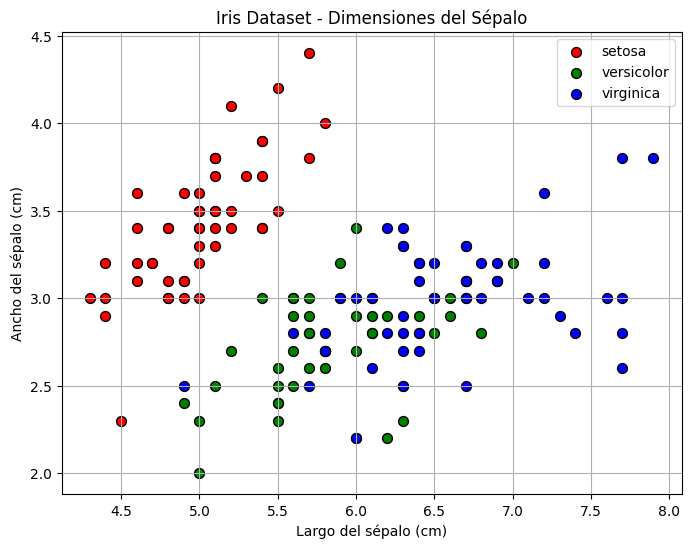

In [11]:
# Cargar la base de datos Iris
iris = datasets.load_iris()
X = iris.data[:, :2]  # Usar solo las dos primeras columnas: largo y ancho del sépalo
y = iris.target       # Las etiquetas de especie

# Dividir en entrenamiento y testeo (70% entrenamiento, 30% testeo)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Graficar los datos
plt.figure(figsize=(8, 6))
colors = ['red', 'green', 'blue']
labels = iris.target_names

for i, color in enumerate(colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=labels[i], edgecolor='k', s=50)

plt.xlabel('Largo del sépalo (cm)')
plt.ylabel('Ancho del sépalo (cm)')
plt.title('Iris Dataset - Dimensiones del Sépalo')
plt.legend()
plt.grid(True)
plt.show()

## **Clasificación LDA**

<p align=center>
    <image src="https://github.com/walteraguirre/TPS/blob/main/TP04/imagenes/ej2.png?raw=true" alt="ejercicio LDA">
</p>

---

El Análisis Discriminante Lineal (LDA) es un modelo generativo para clasificación que asume que los datos de cada clase siguen una distribución normal multivariada con la misma matriz de covarianza, pero de medias diferentes.

Este modelo, asume que $\hat{p}(x)$ es una mezcla de gaussianas, es decir, podemos expresar ésta densidad de probabilidad total de la siguiente manera:

$$
\hat{p}(x) = \sum_{k=1}^K c_k \cdot \frac{1}{(2\pi)^{d/2} |\Sigma|^{1/2}} \exp\left( -\frac{1}{2} (x - \mu_k)^T \Sigma^{-1} (x - \mu_k) \right)
$$

donde:

- $\mu_k$ es el vector de medias para la clase $k$.
- $\Sigma$ es la matriz de covarianza común entre las clases.
- $c_k$ es la probabilidad a priori de la clase $k$. 

Nosotros queremos estimar la probabilidad $\hat{P}(x | y)$, es decir, la probabilidad de que una muestra $x$ pertenezca a la clase $y$. Utilizando la regla de Bayes:

$$
\hat{P}(y|x) = \frac{\hat{P}(x|y) \cdot P(y)}{\hat{p}(x)}
$$

Desarrollando llegamos a la siguiente expresión:

$$
\hat{P}(y|x) = \frac{e^{\mu_y^T \Sigma^{-1} x - \frac{1}{2} \mu_y^T \Sigma^{-1} \mu_y + \log(c_y)}}{\sum_{k=1}^{K} e^{\mu_k^T \Sigma^{-1} x - \frac{1}{2} \mu_k^T \Sigma^{-1} \mu_k + \log(c_k)}}
$$

Dada la forma de $\hat{P}(y|x)$ podemos relacionarlo con la regresión logística. Si asumimos que $w_y = \Sigma^{-1} \ \mu_y$ y que $b_y = - \frac{1}{2} \ \mu_y^T \ \Sigma^{-1} \ \mu_y + \log(c_y)$, podemos decir que $\hat{P}(y|x)$ es la softmax. 

Por lo tanto, la elección del máximo queda de la siguiente manera:

$$
\arg\max_{y} \, \hat{P}(y|x) = \arg\max_{y} \, w_y^T x + b_y
$$

Esto separa las clases mediante hiperplanos.

Para poder entrenar un clasificador LDA, es necesario estimar los parámetros del modelo: la media de cada clase, la matriz de covarianza común y las probabilidades a priori. Estos parámetros se obtienen a partir de estimadores insesgados.

Dado un conjunto de entrenamiento $\mathcal{D} = \{(x_i, y_i)\}_{i=1}^n$, se define $\mathcal{D}_k$ como el subconjunto de muestras que pertenecen a la clase $k$. A partir de ahí, se calcula:

- La probabilidad a priori de la clase $k$:  
  $$
  c_k = \frac{\#\mathcal{D}_k}{n}
  $$

- El vector de medias de la clase $k$:  
  $$
  \mu_k = \frac{1}{\#\mathcal{D}_k} \sum_{x \in \mathcal{D}_k} x
  $$

- La matriz de covarianza de la clase $k$:  
  $$
  \Sigma_k = \frac{1}{\#\mathcal{D}_k - 1} \sum_{x \in \mathcal{D}_k} (x - \mu_k)(x - \mu_k)^T
  $$

- Finalmente, la matriz de covarianza común entre todas las clases (solo en LDA), se estima como:  
  $$
  \Sigma = \frac{1}{n - K} \sum_{k=1}^K (\# \mathcal{D}_k - 1)\Sigma_k
  $$

Estos estimadores permiten construir el modelo probabilístico que utiliza LDA para clasificar nuevas muestras.


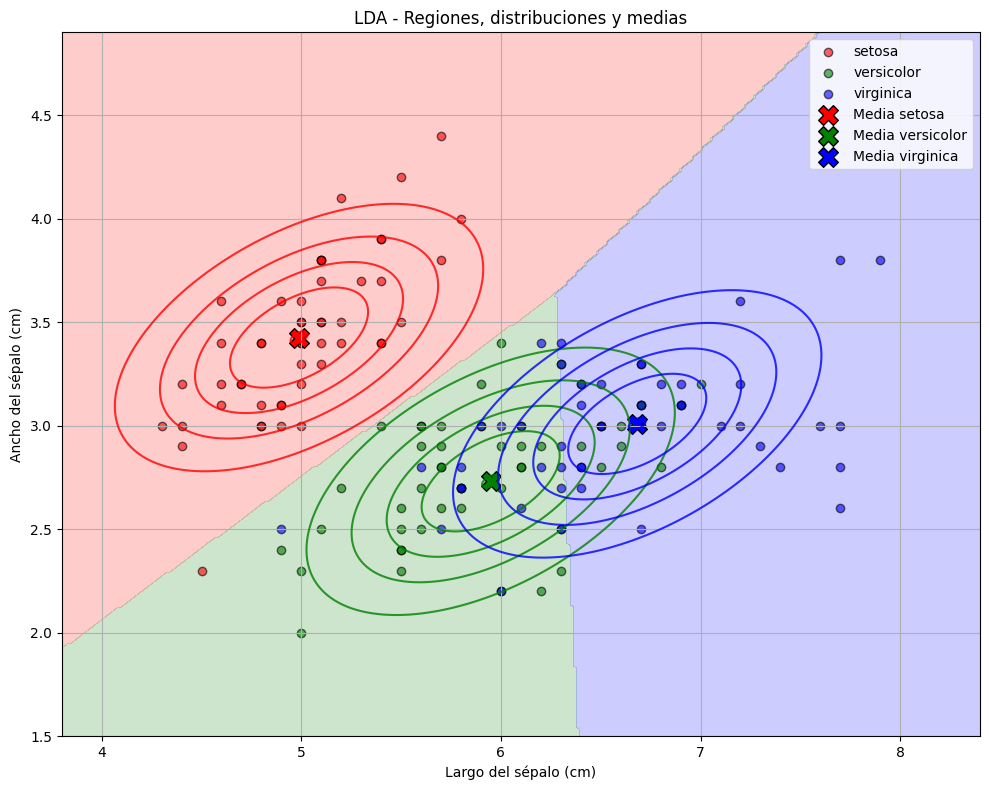

In [12]:
# ===== Clase común para LDA y QDA =====
class GaussianDiscriminantAnalysis:
    def __init__(self, mode='lda'):
        assert mode in ['lda', 'qda'], "mode debe ser 'lda' o 'qda'"
        self.mode = mode
        self.means_ = None
        self.covs_ = None
        self.priors_ = None
        self.classes_ = None
        self.shared_cov_ = None
        self.inv_shared_cov_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_features = X.shape[1]
        self.means_ = []
        self.covs_ = []
        self.priors_ = []

        for cls in self.classes_:
            X_cls = X[y == cls]
            mean = X_cls.mean(axis=0)
            cov = np.cov(X_cls.T)
            self.means_.append(mean)
            self.covs_.append(cov)
            self.priors_.append(len(X_cls) / len(X))

        self.means_ = np.array(self.means_)
        self.covs_ = np.array(self.covs_)
        self.priors_ = np.array(self.priors_)

        if self.mode == 'lda':
            # calcular covarianza común (promedio ponderado)
            pooled_cov = np.zeros((n_features, n_features))
            for i, cls in enumerate(self.classes_):
                X_cls = X[y == cls]
                pooled_cov += (X_cls.shape[0] - 1) * self.covs_[i]
            self.shared_cov_ = pooled_cov / (len(X) - len(self.classes_))
            self.inv_shared_cov_ = np.linalg.inv(self.shared_cov_)

    def predict_proba(self, X):
        probs = []
        for x in X:
            scores = []
            for i, cls in enumerate(self.classes_):
                mean = self.means_[i]
                prior = self.priors_[i]

                if self.mode == 'lda':
                    delta = x - mean
                    score = -0.5 * delta.T @ self.inv_shared_cov_ @ delta + np.log(prior)
                else:  # QDA
                    cov = self.covs_[i]
                    inv_cov = np.linalg.inv(cov)
                    det_cov = np.linalg.det(cov)
                    delta = x - mean
                    score = -0.5 * delta.T @ inv_cov @ delta - 0.5 * np.log(det_cov) + np.log(prior)

                scores.append(score)

            scores = np.array(scores)
            exp_scores = np.exp(scores - np.max(scores))  # para evitar overflow
            probs.append(exp_scores / np.sum(exp_scores))
        return np.array(probs)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)


# Entrenar modelo
lda = GaussianDiscriminantAnalysis(mode='lda')
lda.fit(X_train, y_train)

# === Visualización ===
colors = ['red', 'green', 'blue']
labels = iris.target_names
plt.figure(figsize=(10, 8))

# 1. Dibujar regiones de decisión
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = lda.predict(grid).reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2, levels=np.arange(len(lda.classes_) + 1) - 0.5, colors=colors)

# 2. Scatter de datos reales
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=labels[i], edgecolor='k', alpha=0.6)

# 3. Medias y curvas de nivel
for i, mean in enumerate(lda.means_):
    plt.scatter(*mean, c=colors[i], s=200, marker='X', edgecolor='black', label=f'Media {labels[i]}')

    cov = lda.shared_cov_ if lda.mode == 'lda' else lda.covs_[i]
    rv = multivariate_normal(mean=mean, cov=cov)
    zz = rv.pdf(grid).reshape(xx.shape)
    plt.contour(xx, yy, zz, levels=5, colors=colors[i], alpha=0.8)

# Estética del gráfico
plt.xlabel('Largo del sépalo (cm)')
plt.ylabel('Ancho del sépalo (cm)')
plt.title('LDA - Regiones, distribuciones y medias')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
# Evaluar en test
y_pred = lda.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy en test: {acc * 100:.2f}%")

Accuracy en test: 75.56%


## **Síntesis**



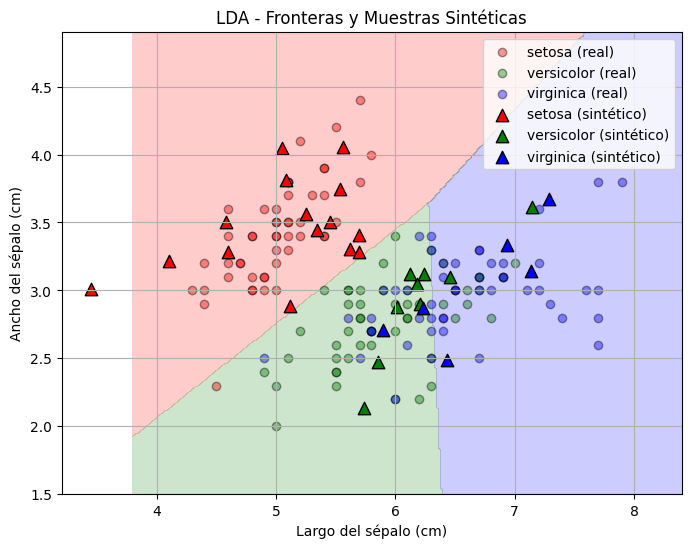

In [14]:
# === Generar 30 muestras sintéticas usando el modelo LDA ===

np.random.seed(42)  # para reproducibilidad
n_samples = 30
synthetic_X = []
synthetic_y = []

for _ in range(n_samples):
    # Elegir clase según prior
    cls = np.random.choice(lda.classes_, p=lda.priors_)
    
    # Muestrear desde la gaussiana correspondiente
    cov = lda.shared_cov_ if lda.mode == 'lda' else lda.covs_[i]
    sample = np.random.multivariate_normal(mean=lda.means_[cls], cov=cov)
    
    synthetic_X.append(sample)
    synthetic_y.append(cls)

synthetic_X = np.array(synthetic_X)
synthetic_y = np.array(synthetic_y)

# === Gráfico con regiones + muestras sintéticas ===

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=np.arange(len(lda.classes_) + 1) - 0.5, colors=colors, alpha=0.2)

# Scatter de datos originales
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=f'{labels[i]} (real)', edgecolor='k', alpha=0.4)

# Muestras sintéticas
for i, color in enumerate(colors):
    idx = synthetic_y == i
    plt.scatter(synthetic_X[idx, 0], synthetic_X[idx, 1], c=color, marker='^',
                label=f'{labels[i]} (sintético)', edgecolor='black', s=80)

plt.xlabel('Largo del sépalo (cm)')
plt.ylabel('Ancho del sépalo (cm)')
plt.title('LDA - Fronteras y Muestras Sintéticas')
plt.legend()
plt.grid(True)
plt.show()


## **Discriminante Cuadrático**

</p align=center>
    <image src="https://github.com/walteraguirre/TPS/blob/main/TP04/imagenes/ej4.png?raw=true"  alt="enunciado QDA">
<p>



---


QDA, al igual que LDA, es un modelo generativo de clasificación, pero a diferencia de LDA, en este caso ya no suponemos una matriz de covarianza común entre clases sino que cada clase tiene su propia matriz de covarianza $\Sigma_k$. 

Para QDA, se realizan las siguientes suposiciones:

- La variable de clase $ Y $ sigue una distribución categórica:
  $$
  Y \sim \text{Cat}(\{c_1, \cdots, c_K\})
  $$
- La variable de entrada $ X $ condicionada a la clase $ Y = k $ sigue una normal multivariada con media $ \mu_k $ y covarianza $ \Sigma_k $:
  $$
  X \mid Y = k \sim \mathcal{N}(\mu_k, \Sigma_k)
  $$


De esta forma, la densidad de probabilidad total de x es una mezcla de gaussianas, que se puede expresar de la siguiente manera:

$$
\hat{p}(x) = \sum_{k=1}^{K} c_k \cdot \frac{e^{- \frac{1}{2} (x - \mu_k)^T \Sigma_k^{-1} (x - \mu_k)}}{(2\pi)^{d/2} |\Sigma_k|^{1/2}}
$$



Con todas estas suposiciones, queremos estimar la probabilidad $\hat{P}(y|x)$, cuya expresión es la siguiente:

$$
\hat{P}(y|x) = \frac{e^{- \frac{1}{2} (x - \mu_y)^T \Sigma_y^{-1} (x - \mu_y) + \log(c_y) - \frac{1}{2} \log |\Sigma_y|} }{\sum_{k=1}^{K} e^{- \frac{1}{2} (x - \mu_k)^T \Sigma_k^{-1} (x - \mu_k)+ \log(c_k) - \frac{1}{2} \log |\Sigma_k|} }
$$


Para predecir la clase más probable, se elige aquella que maximiza:

$$
\arg\max_y \left[ -\frac{1}{2} (x - \mu_y)^T \Sigma_y^{-1} (x - \mu_y) + \log(c_y) - \frac{1}{2} \log |\Sigma_y| \right]
$$



> A diferencia de LDA, la frontera de decisión **no es lineal**, sino **cuadrática**, debido a que cada clase tiene su propia matriz de covarianza.


Accuracy QDA en test: 71.11%


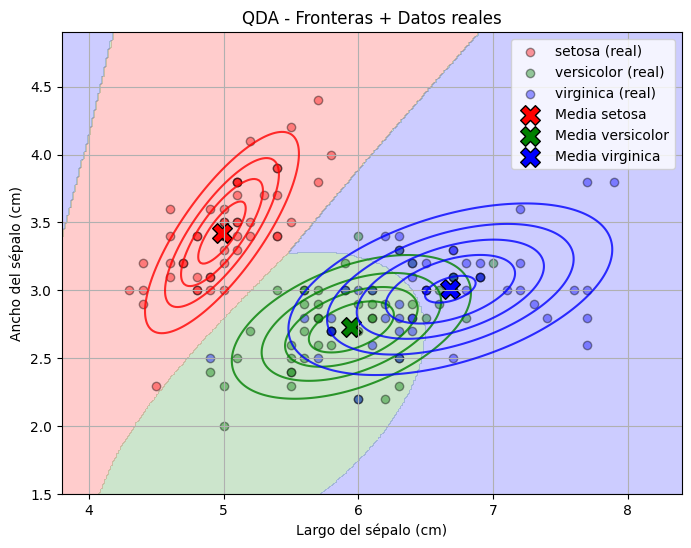

In [15]:
#entrenamos el modelo 
qda = GaussianDiscriminantAnalysis(mode='qda')
qda.fit(X_train, y_train)

# Accuracy en test
y_pred_qda = qda.predict(X_test)
acc_qda = accuracy_score(y_test, y_pred_qda)
print(f"Accuracy QDA en test: {acc_qda * 100:.2f}%")

rv = multivariate_normal(mean=mean, cov=qda.covs_[i])  # en vez de shared_cov_


# ===== Grilla para fronteras =====
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = qda.predict(grid).reshape(xx.shape)

# ===== Gráfico 1: Datos reales =====
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=np.arange(len(qda.classes_) + 1) - 0.5, colors=colors, alpha=0.2)

# Datos reales
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=f'{labels[i]} (real)', edgecolor='k', alpha=0.4)

# Medias y gaussianas
for i, mean in enumerate(qda.means_):
    plt.scatter(*mean, c=colors[i], s=200, marker='X', edgecolor='black', label=f'Media {labels[i]}')
    cov = qda.shared_cov_ if qda.mode == 'lda' else qda.covs_[i]
    rv = multivariate_normal(mean=mean, cov=cov)
    zz = rv.pdf(grid).reshape(xx.shape)
    plt.contour(xx, yy, zz, levels=5, colors=colors[i], alpha=0.8)

plt.xlabel('Largo del sépalo (cm)')
plt.ylabel('Ancho del sépalo (cm)')
plt.title(f'{qda.mode.upper()} - Fronteras + Datos reales')
plt.legend()
plt.grid(True)
plt.show()



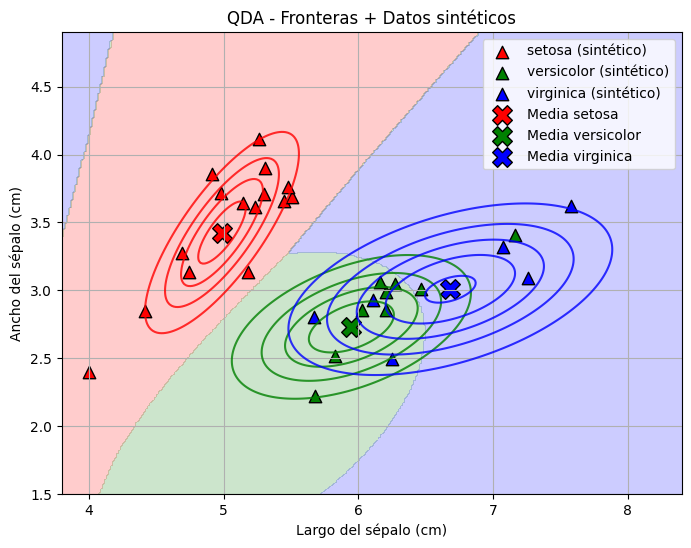

In [16]:
# ===== Generar muestras sintéticas =====
np.random.seed(42)
synthetic_X = []
synthetic_y = []
for _ in range(30):
    cls = np.random.choice(qda.classes_, p=qda.priors_)
    mean = qda.means_[cls]
    cov = qda.shared_cov_ if qda.mode == 'lda' else qda.covs_[cls]
    sample = np.random.multivariate_normal(mean, cov)
    synthetic_X.append(sample)
    synthetic_y.append(cls)

synthetic_X = np.array(synthetic_X)
synthetic_y = np.array(synthetic_y)

# ===== Gráfico 2: Datos sintéticos =====
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=np.arange(len(qda.classes_) + 1) - 0.5, colors=colors, alpha=0.2)

# Muestras sintéticas
for i, color in enumerate(colors):
    idx = synthetic_y == i
    plt.scatter(synthetic_X[idx, 0], synthetic_X[idx, 1], c=color, marker='^',
                label=f'{labels[i]} (sintético)', edgecolor='black', s=80)

# Medias y gaussianas
for i, mean in enumerate(qda.means_):
    plt.scatter(*mean, c=colors[i], s=200, marker='X', edgecolor='black', label=f'Media {labels[i]}')
    cov = qda.shared_cov_ if qda.mode == 'lda' else qda.covs_[i]
    rv = multivariate_normal(mean=mean, cov=cov)
    zz = rv.pdf(grid).reshape(xx.shape)
    plt.contour(xx, yy, zz, levels=5, colors=colors[i], alpha=0.8)

plt.xlabel('Largo del sépalo (cm)')
plt.ylabel('Ancho del sépalo (cm)')
plt.title(f'{qda.mode.upper()} - Fronteras + Datos sintéticos')
plt.legend()
plt.grid(True)
plt.show()


## **KNN**

Accuracy KNN (k=6) en test: 84.44%


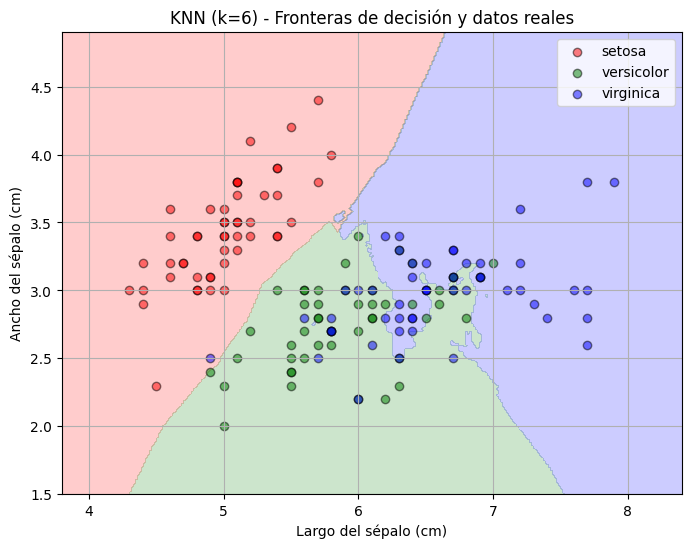

In [17]:

class KNN:
    def __init__(self, k=6):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict_proba(self, X):
        probs = []
        for x in X:
            dists = np.linalg.norm(self.X_train - x, axis=1)
            knn_indices = np.argsort(dists)[:self.k]
            knn_labels = self.y_train[knn_indices]
            counts = Counter(knn_labels)
            prob = np.array([counts.get(cls, 0) / self.k for cls in np.unique(self.y_train)])
            probs.append(prob)
        return np.array(probs)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)
    
# Entrenar modelo
knn = KNN(k=6)
knn.fit(X_train, y_train)

# Accuracy
y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy KNN (k=6) en test: {acc_knn * 100:.2f}%")

# Scatter con fronteras de decisión
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = knn.predict(grid).reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.2, levels=np.arange(len(lda.classes_) + 1) - 0.5, colors=colors)

# Datos reales
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=f'{labels[i]}', edgecolor='k', alpha=0.5)

plt.xlabel('Largo del sépalo (cm)')
plt.ylabel('Ancho del sépalo (cm)')
plt.title('KNN (k=6) - Fronteras de decisión y datos reales')
plt.legend()
plt.grid(True)
plt.show()

